# Battery Cooling Simulation from Real Drive Cycle Data
This notebook simulates realistic battery pack cooling using real-world drive cycles stored in a folder. It uses liquid cooling logic with per-zone thermal dynamics and shared pump modeling.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os
import sys
import tensorflow as tf
tf.disable_v2_behavior()
import sys


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
force_rebuild_core = False         # ⬅️ Set True to force re-concatenation
force_regenerate_gan = False       # ⬅️ Set True to force TimeGAN re-generation
core_path = "/home/keshav/Documents/reserch_code/core.csv"
generated_path = "/home/keshav/Documents/reserch_code/core_plus_generated.csv"
checkpoint_dir = "/home/keshav/Documents/reserch_code/checkpoints"
drive_cycle_folder = "/home/keshav/Documents/reserch_code/drive_cycles"

os.makedirs("data", exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

In [3]:
# Add the TimeGAN repo path so you can import its modules
timegan_repo_path = "/home/keshav/TimeGAN"  # Update if your path is different
if timegan_repo_path not in sys.path:
    sys.path.append(timegan_repo_path)

In [4]:
def noise(temps, scale=0.15, seed=42):
    """
    Adds low-frequency noise to simulate realistic battery cell variation.
    Inputs:
        temps: np.ndarray (time × zones)
        scale: noise magnitude (°C)
        seed: random seed for reproducibility
    Returns:
        temps + gen_ai variation (same shape)
    """
    np.random.seed(seed)
    raw_noise = np.random.normal(0, 1, temps.shape)
    b, a = butter(2, 0.05)  # Low-pass filter
    smooth_noise = filtfilt(b, a, raw_noise, axis=0)
    return temps + scale * smooth_noise


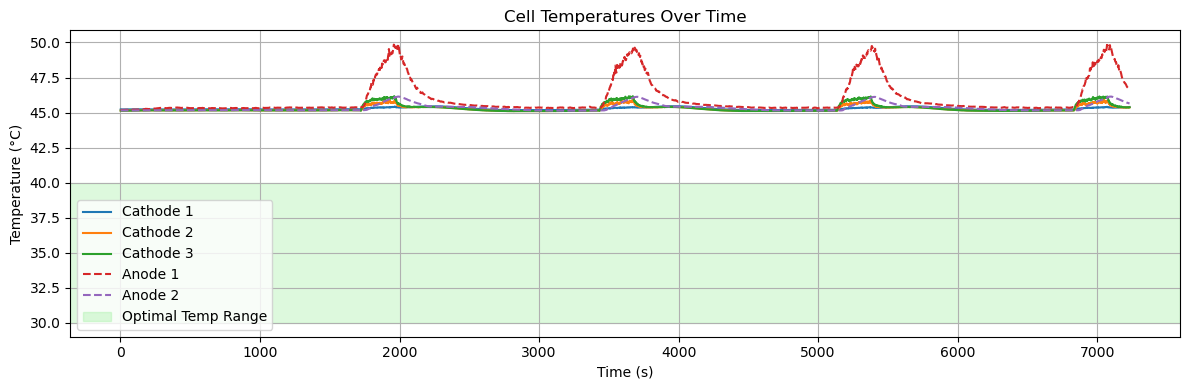

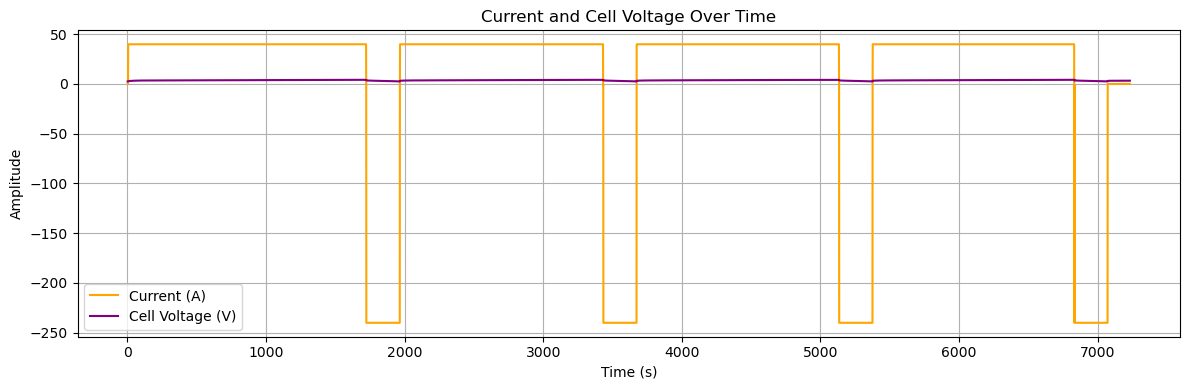

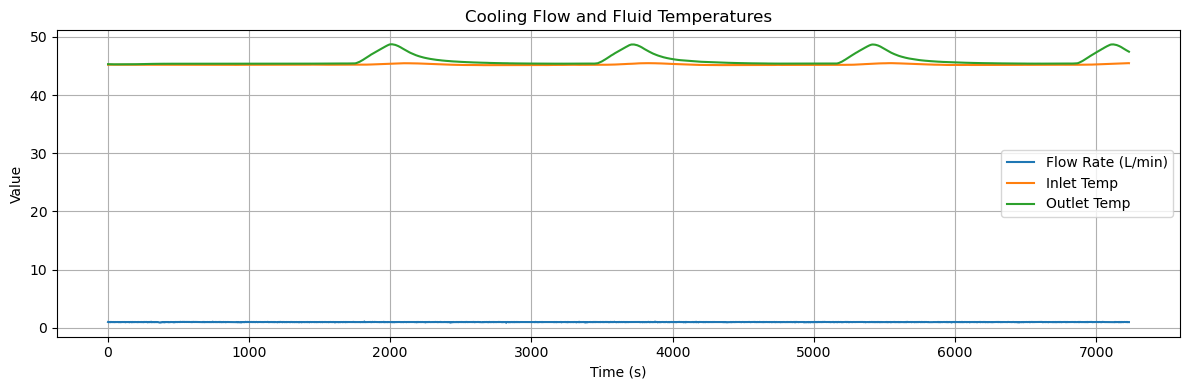

In [5]:
# Load and clean the reference CSV
ref_path = "/home/keshav/Documents/reserch_code/ImmersiveCoolingExp_DatasheetCycle.csv"  # Adjust if path changes
ref_df_raw = pd.read_csv(ref_path)

# Split single tab-separated column
ref_df = ref_df_raw.iloc[:, 0].str.split('\t', expand=True)

# Assign correct column names
ref_df.columns = [
    "Time [sec]",
    "Flow [L/min]",
    "Outlet Temp [°C]",
    "Inlet Temp [°C]",
    "Cathode Temp 1 [°C]",
    "Cathode Temp 2 [°C]",
    "Cathode Temp 3 [°C]",
    "Anode Temp 1 [°C]",
    "Anode Temp 2 [°C]",
    "Current [A]",
    "V_cell [V]"
]

# Drop old header row and convert all to numeric
ref_df = ref_df.drop(index=0).reset_index(drop=True)
ref_df = ref_df.apply(pd.to_numeric, errors='coerce')

# Extract time axis
time_ref = ref_df["Time [sec]"]

# 🔧 Plot all cathode/anode temperatures
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Cathode Temp 1 [°C]"], label="Cathode 1")
plt.plot(time_ref, ref_df["Cathode Temp 2 [°C]"], label="Cathode 2")
plt.plot(time_ref, ref_df["Cathode Temp 3 [°C]"], label="Cathode 3")
plt.plot(time_ref, ref_df["Anode Temp 1 [°C]"], linestyle="--", label="Anode 1")
plt.plot(time_ref, ref_df["Anode Temp 2 [°C]"], linestyle="--", label="Anode 2")
plt.axhspan(30, 40, color='lightgreen', alpha=0.3, label="Optimal Temp Range")
plt.title("Cell Temperatures Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ⚡ Plot current and cell voltage
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Current [A]"], label="Current (A)", color="orange")
plt.plot(time_ref, ref_df["V_cell [V]"], label="Cell Voltage (V)", color="purple")
plt.title("Current and Cell Voltage Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 💧 Plot flow rate and inlet/outlet temperatures
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Flow [L/min]"], label="Flow Rate (L/min)")
plt.plot(time_ref, ref_df["Inlet Temp [°C]"], label="Inlet Temp")
plt.plot(time_ref, ref_df["Outlet Temp [°C]"], label="Outlet Temp")
plt.title("Cooling Flow and Fluid Temperatures")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
if not os.path.exists(core_path) or force_rebuild_core:
    print("🔄 Building core.csv from drive_cycles...")

    dfs = []
    all_txts = sorted(f for f in os.listdir(drive_cycle_folder) if f.endswith(".txt"))

    for file in all_txts:
        path = os.path.join(drive_cycle_folder, file)
        try:
            df = pd.read_csv(path, sep='\t', engine='python', skiprows=1, names=["Time", "Speed"], encoding="utf-16")
        except Exception as e:
            try:
                df = pd.read_csv(path, sep='\t', engine='python', skiprows=1, names=["Time", "Speed"], encoding="ISO-8859-1")
            except Exception as e2:
                print(f"Skipping {file}: {e2}")
                continue
        df = df.dropna()
        df["File"] = file
        dfs.append(df)

    # Combine and compute derived fields
    drive_df = pd.concat(dfs, ignore_index=True)
    drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    drive_df["Acceleration"] = drive_df["Speed_mps"].diff().fillna(0)
    drive_df["Power_W"] = (1600 * drive_df["Speed_mps"] * drive_df["Acceleration"]).clip(lower=0)
    drive_df["CumulativeTime"] = drive_df.index

    # Save core.csv
    drive_df.to_csv(core_path, index=False)
    print(f"✅ core.csv saved with {len(drive_df)} rows")

else:
    drive_df = pd.read_csv(core_path)
    print(f"📄 core.csv loaded with {len(drive_df)} rows")


# Define time and power input arrays
time = np.arange(len(drive_df))
power_input = drive_df["Power_W"].values
timesteps = len(time)


/home/keshav/.conda/envs/data-analysis-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


📄 core.csv loaded with 35320878 rows


In [7]:
def normalizer(data, method='minmax'):
    """
    Normalize time-series data to 0–1 range using min-max per feature.
    Returns normalized data and (min, max) tuples for inverse transform.
    """
    _, _, dim = data.shape
    norm_data = data.copy()
    norm_parameters = []

    if method == 'minmax':
        for i in range(dim):
            min_val = np.min(norm_data[:, :, i])
            max_val = np.max(norm_data[:, :, i])
            norm_data[:, :, i] = (norm_data[:, :, i] - min_val) / (max_val - min_val + 1e-7)
            norm_parameters.append([min_val, max_val])

    return norm_data, norm_parameters

def renormalization(norm_data, norm_parameters):
    """
    Inverse of min-max normalization using stored (min, max) pairs.
    """
    _, _, dim = norm_data.shape
    renorm_data = norm_data.copy()

    for i in range(dim):
        min_val, max_val = norm_parameters[i]
        renorm_data[:, :, i] = renorm_data[:, :, i] * (max_val - min_val + 1e-7) + min_val

    return renorm_data


In [8]:
if not os.path.exists(generated_path) or force_regenerate_gan:
    print("🧠 Running TimeGAN to extend core data...")

    from timegan import timegan
    tf.compat.v1.reset_default_graph()

    # Parameters
    timegan_multiplier = 10
    seq_len = 24
    epochs = 500
    model = 'lstm'

    # Prepare training data
    speed_data = drive_df["Speed"].values.reshape(-1, 1)
    pad_len = seq_len - (len(speed_data) % seq_len)
    if pad_len > 0:
        speed_data = np.pad(speed_data, ((0, pad_len)), mode='edge')

    seq_data = speed_data.reshape(-1, seq_len, 1)
    norm_data, norm_params = normalizer(seq_data, 'minmax')

    # TimeGAN parameters
    parameters = {
        'module': model,
        'hidden_dim': 24,
        'num_layer': 6,
        'iterations': epochs,
        'batch_size': 64,
        'seq_len': seq_len,
        'z_dim': 32
    }

    generated_data = timegan(norm_data, parameters)
    generated_flat = renormalization(generated_data, norm_params).reshape(-1, 1)

    # Select how much to append
    n_generated = int(len(drive_df) * (timegan_multiplier - 1))
    gen_speed = generated_flat[:n_generated]

    # Create extension DataFrame
    ext_df = pd.DataFrame({
        "Speed": gen_speed.flatten(),
        "Time": np.arange(len(drive_df), len(drive_df) + len(gen_speed))
    })

    # Combine original + generated
    drive_df = pd.concat([drive_df, ext_df], ignore_index=True)
    drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    drive_df["Acceleration"] = drive_df["Speed_mps"].diff().fillna(0)
    drive_df["Power_W"] = (1600 * drive_df["Speed_mps"] * drive_df["Acceleration"]).clip(lower=0)

    # Label GAN part
    split_idx = int(len(drive_df) / timegan_multiplier)
    drive_df.loc[split_idx:, "File"] = "Generated"

    last_time = drive_df.loc[split_idx - 1, "CumulativeTime"] if "CumulativeTime" in drive_df else split_idx - 1
    drive_df.loc[split_idx:, "CumulativeTime"] = np.arange(last_time + 1, last_time + 1 + len(drive_df) - split_idx)

    # Save
    drive_df.to_csv(generated_path, index=False)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    drive_df.to_csv(f"{checkpoint_dir}/core_plus_generated_{ts}.csv", index=False)
    print(f"💾 Saved: core_plus_generated.csv and timestamped checkpoint")

else:
    drive_df = pd.read_csv(generated_path)
    print(f"📄 core_plus_generated.csv loaded with {len(drive_df)} rows")

📄 core_plus_generated.csv loaded with 61070 rows


In [9]:
#printing drive_df after extension
print(drive_df.head())
print(drive_df.tail())

  Time  Speed        File  Speed_mps  Acceleration  Power_W  CumulativeTime
0    0    0.0  ftpcol.txt        0.0           0.0      0.0             0.0
1    1    0.0  ftpcol.txt        0.0           0.0      0.0             1.0
2    2    0.0  ftpcol.txt        0.0           0.0      0.0             2.0
3    3    0.0  ftpcol.txt        0.0           0.0      0.0             3.0
4    4    0.0  ftpcol.txt        0.0           0.0      0.0             4.0
        Time     Speed       File  Speed_mps  Acceleration      Power_W  \
61065  61065  0.098984  Generated   0.044250     -0.000271     0.000000   
61066  61066  0.098544  Generated   0.044053     -0.000197     0.000000   
61067  61067  2.448769  Generated   1.094698      1.050645  1840.221108   
61068  61068  0.168289  Generated   0.075232     -1.019466     0.000000   
61069  61069  0.066653  Generated   0.029797     -0.045435     0.000000   

       CumulativeTime  
61065         61065.0  
61066         61066.0  
61067         61067.0

In [10]:
# --- Reload core or extended drive_df after restart ---
use_generated = False  # True = use core_plus_generated.csv
fraction = 0.01        # 1 = 100% of rows, 0.01 = 1% of rows

core_path = "/home/keshav/Documents/reserch_code/core.csv"
generated_path = "/home/keshav/Documents/reserch_code/core_plus_generated.csv"

# Load the appropriate file
drive_df = pd.read_csv(generated_path if use_generated else core_path)

# Keep only the requested fraction in chronological order
if fraction < 1:
    num_rows = int(len(drive_df) * fraction)
    drive_df = drive_df.iloc[:num_rows].reset_index(drop=True)

print(f"📄 Loaded {len(drive_df):,} rows ({fraction*100:.2f}% of dataset)")

# Vehicle parameters
m = 1800  # kg (mass of car)
g = 9.81  # gravity
Cd = 0.28  # drag coefficient
A = 2.3  # frontal area (m²)
Crr = 0.01  # rolling resistance
rho = 1.225  # air density (kg/m³)
eff = 0.9  # drivetrain efficiency
dt = 1  # timestep (seconds)

# Update derived fields (just in case)
drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704

# Use a slightly larger window for more robust smoothing. Use this smoothed value for ALL subsequent physics.
smooth_speed = drive_df["Speed_mps"].rolling(5, center=True).mean().fillna(method="bfill").fillna(method="ffill")
drive_df["Acceleration"] = smooth_speed.diff().fillna(0) / dt

# --- Physics-based forces using SMOOTHED speed ---
F_aero = 0.5 * rho * Cd * A * smooth_speed**2
F_roll = m * g * (Crr + 0.0005 * smooth_speed)
F_inertia = m * drive_df["Acceleration"]  # This already uses smoothed data

F_total = F_aero + F_roll + F_inertia

# --- Power in W, also using SMOOTHED speed ---
drive_df["Power_W"] = ((F_total * smooth_speed) / eff).clip(lower=0)


# Time & power for simulation
time = np.arange(len(drive_df))
power_input = drive_df["Power_W"].values
timesteps = len(time)

print(f"✅ Reloaded {'core_plus_generated' if use_generated else 'core'} data with {timesteps} steps into drive_df")


/home/keshav/.conda/envs/data-analysis-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


📄 Loaded 353,208 rows (1.00% of dataset)
✅ Reloaded core data with 353208 steps into drive_df


In [11]:
print(f"Max accel: {drive_df['Acceleration'].max():.2f} m/s²")
print(f"Max power: {drive_df['Power_W'].max():,.0f} W")

Max accel: 2.73 m/s²
Max power: 118,519 W


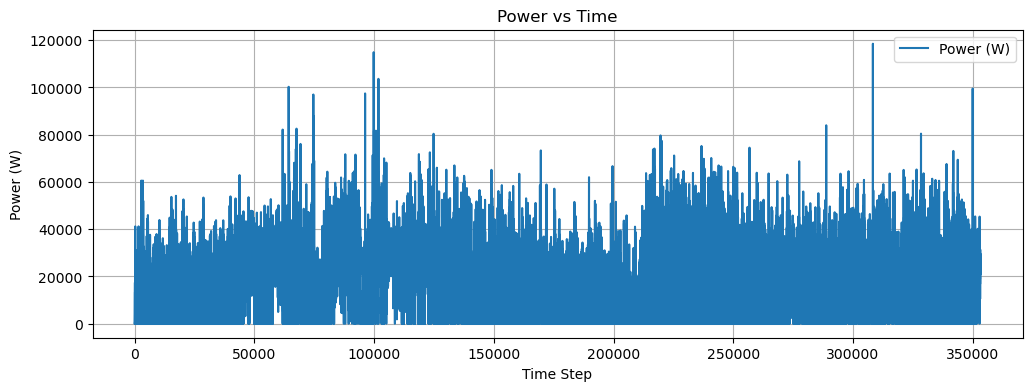

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(drive_df["Power_W"], label="Power (W)")
plt.title("Power vs Time")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.grid()
plt.legend()
plt.show()

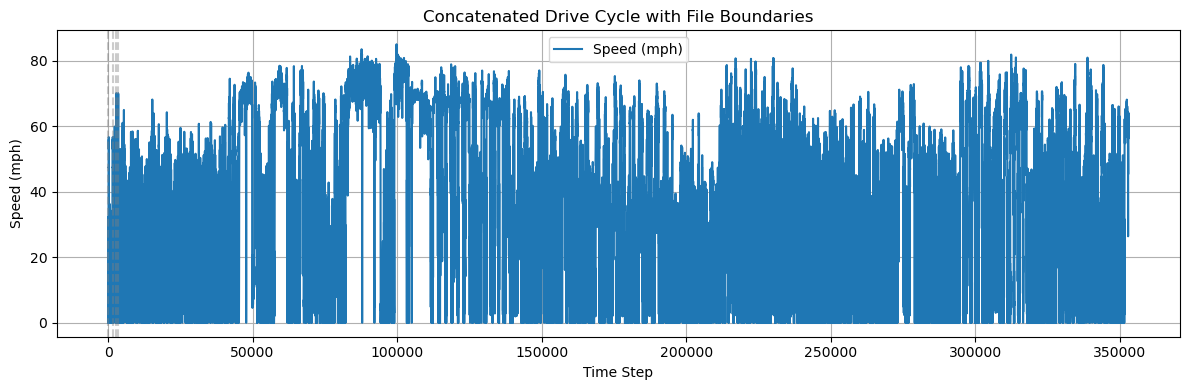

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(drive_df["CumulativeTime"], drive_df["Speed"], label="Speed (mph)")

# Identify file boundaries and mark them
boundaries = drive_df["File"].ne(drive_df["File"].shift()).cumsum()
boundary_indices = drive_df.groupby(boundaries).head(1).index

for i in boundary_indices:
    plt.axvline(i, color='gray', linestyle='--', alpha=0.4)

plt.title("Concatenated Drive Cycle with File Boundaries")
plt.xlabel("Time Step")
plt.ylabel("Speed (mph)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# --- Core thermal parameters ---
num_zones = 40
initial_temp = 35.0  # starting temperature
optimum_temp_range = (25.0, 35.0)
cooling_threshold = 30.0

# --- Thermal & Pump System Parameters ---
a_pump = 0.005  # Adjusted to scale power usage realistically
b_pump = 0.1    # Linear term for base flow

# --- System-wide physical constants ---
cooling_time_constant = 3  # seconds for coolant effect to stabilize
heating_delay_steps = 3    # delay steps for power-to-temp rise

# --- Per-zone physical properties (based on SoH, contact, etc.) ---

# Initial SoC: slightly varied
initial_soc = np.clip(np.random.normal(0.5, 0.05, num_zones), 0.3, 0.7)

# State of Health (SoH): 1 = new, <1 = aged
soh = np.clip(np.random.normal(0.95, 0.03, num_zones), 0.8, 1.0)

# Internal resistance (higher = more heat)
base_r_internal = 0.01  # ohms
r_internal = base_r_internal / soh + np.random.normal(0, 0.001, num_zones)
r_internal = np.clip(r_internal, 0.005, 0.03)  # Prevent unrealistic high resistance

# Heat capacity (thermal mass)
heat_capacity = np.clip(np.random.normal(14.0, 1.0, num_zones), 10.0, 18.0)

# Cooling efficiency: higher at edges
edge_factor = np.abs(np.linspace(-1, 1, num_zones))
cooling_efficiency = 1 + 0.3 * edge_factor + np.random.normal(0, 0.05, num_zones)

# Thermal noise: time & space correlated
def correlated_noise(shape, scale=0.02):
    base = np.random.normal(0, scale, shape)
    for t in range(1, shape[0]):
        base[t] = 0.6 * base[t] + 0.3 * base[t - 1] + 0.1 * np.roll(base[t], 1)
    return base

thermal_noise = correlated_noise((timesteps, num_zones), scale=0.02)

# Lateral conduction (more at edges)
left_bias_conductance = 0.03 + 0.03 * np.abs(np.linspace(-1, 1, num_zones - 1))

# --- System states ---
temps = np.full((timesteps, num_zones), initial_temp)
valves = np.zeros((timesteps, num_zones))
coolant_flow = np.zeros((timesteps, num_zones))
pump_power = np.zeros(timesteps)

# --- Delay buffer for heating effect (using exponential smoothing) ---
alpha = 0.2  # smoothing factor (lower = smoother)
delayed_power = np.zeros(timesteps)
delayed_power[0] = power_input[0]  # initialize with first value

for i in range(1, timesteps):
    delayed_power[i] = alpha * power_input[i] + (1 - alpha) * delayed_power[i - 1]

# # --- Cap power input to realistic EV limits ---
# max_power_kw = 200  # still a fair cap
# delayed_power = np.clip(delayed_power, 0, max_power_kw)

print("🔍 DEBUG OUTPUT")

# Check delayed power distribution
print(f"▶ Delayed power (first 40): {delayed_power[:40]}")
print(f"   Min: {delayed_power.min():.2f} kW | Max: {delayed_power.max():.2f} kW")

# Print internal resistance
print(f"▶ Internal resistance range: {r_internal.min():.5f} Ω to {r_internal.max():.5f} Ω")

# Print heat capacity
print(f"▶ Heat capacity range: {heat_capacity.min():.2f} to {heat_capacity.max():.2f} kJ/°C")

# Cooling efficiency distribution
print(f"▶ Cooling efficiency (mean ± std): {np.mean(cooling_efficiency):.2f} ± {np.std(cooling_efficiency):.2f}")

# First few values of noise (just to sanity-check magnitude)
print(f"▶ Thermal noise sample (first timestep): {thermal_noise[0, :40]}")



🔍 DEBUG OUTPUT
▶ Delayed power (first 40): [    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.            39.44560128
   231.96902839   733.33680636  1769.50183758  3581.87531823
  5671.49968555  7372.49154392  8669.90354617  9971.53381315
 10744.08470032 10929.44858501 11113.42487774 10943.52592447
  9697.64143692  8131.81947243  6505.45557794  5204.36446236
  4163.49156988  3330.79325591  2664.63460473  2131.70768378]
   Min: 0.00 kW | Max: 95943.44 kW
▶ Internal resistance range: 0.00888 Ω to 0.01312 Ω
▶ Heat capacity range: 12.23 to 17.02 kJ/°C
▶ Cooling efficiency (mean ± std): 1.18 ± 0.10
▶ Thermal noise sample (first timestep): [ 0.02055261 -0.01468815  0.015955   -0.00380609 -0.00309115  0.01432396
  0.03817331  0.01447148 -0.02175684 -0.01314562  0.02175224  0.02406148
  0.00538008 

In [15]:
max_total_flow = 500.0  # Maximum total allowed flow in % units (tune as needed)
cooling_response = np.zeros(num_zones)  # smooth dynamic cooling state

for t in range(1, timesteps):
    temps_prev = temps[t - 1]

    # Estimate current from power: I = P / V (use nominal voltage)
    voltage_nominal = 44.4  # adjust based on your pack setup
    current = delayed_power[t] / voltage_nominal  # A

    # --- Heat input per zone: Joule heating = I^2 * R_internal[z] ---
    heat_input = (current ** 2) * r_internal * 1e-3  # kW → kJ/s

        # Debug: Print early runaway indicators
    # if t < 30:
    #     print(f"[t={t:02d}] current = {current:.0f} A | avg heat input = {heat_input.mean():.2f} kJ/s | max temp = {temps[t-1].max():.2f}°C")

    raw_valves = np.zeros(num_zones)

    # --- Valve request phase ---
    for z in range(num_zones):
        T = temps_prev[z]

        if T > optimum_temp_range[1]:
            raw_valves[z] = min(100, (T - optimum_temp_range[1]) * 20)
        elif T > cooling_threshold:
            raw_valves[z] = (T - cooling_threshold) / (optimum_temp_range[1] - cooling_threshold) * 30
        else:
            raw_valves[z] = 0

    # --- Normalize valve requests to fit max flow ---
    total_requested_flow = np.sum(raw_valves)
    flow_scaling = min(1.0, max_total_flow / total_requested_flow) if total_requested_flow > 0 else 0
    scaled_valves = raw_valves * flow_scaling
    valves[t] = scaled_valves

    # --- Apply physics zone by zone ---
    for z in range(num_zones):
        T = temps_prev[z]
        T_left = temps_prev[z - 1] if z > 0 else T
        T_right = temps_prev[z + 1] if z < num_zones - 1 else T

        # Neighbor heat conduction
        left_cond = left_bias_conductance[z - 1] * (T_left - T) if z > 0 else 0
        right_cond = left_bias_conductance[z] * (T_right - T) if z < num_zones - 1 else 0

        # Smooth coolant response (simulate fluid ramp-in/out)
        coolant_flow[t, z] = (
            coolant_flow[t - 1, z]
            + (scaled_valves[z] - coolant_flow[t - 1, z]) / cooling_time_constant
        )

        # Cooling effect scaled by cell-specific cooling efficiency
        cooling_effect = 0.5 * coolant_flow[t, z] * cooling_efficiency[z]

        # Final temperature update (note: per-zone heat capacity now)
        dT = (
            heat_input[z]
            + left_cond + right_cond
            - cooling_effect
            + thermal_noise[t, z]
        ) / heat_capacity[z]

        temps[t, z] = T + dT

    # --- Realistic pump power (based on actual delivered flow) ---
    total_actual_flow = np.sum(coolant_flow[t])
    pump_power[t] = a_pump * total_actual_flow**2 + b_pump * total_actual_flow

    if t % 1000 == 0:  # You can change 1 → 10 to print every 10s
        max_temp = temps[t].max()
        avg_temp = temps[t].mean()
        avg_heat = heat_input.mean()
        total_flow = coolant_flow[t].sum()
        
        print(f"[t={t:04d}] "
            f"I={current:.0f} A | "
            f"heat={avg_heat:.2f} kJ/s | "
            f"Tmax={max_temp:.2f}°C | "
            f"Tavg={avg_temp:.2f}°C | "
            f"flow={total_flow:.1f}% | "
            f"pump={pump_power[t]:.2f} W")



[t=1000] I=106 A | heat=0.12 kJ/s | Tmax=30.02°C | Tavg=30.01°C | flow=0.4% | pump=0.04 W
[t=2000] I=262 A | heat=0.74 kJ/s | Tmax=30.21°C | Tavg=30.15°C | flow=40.2% | pump=12.08 W
[t=3000] I=22 A | heat=0.01 kJ/s | Tmax=29.99°C | Tavg=29.97°C | flow=1.5% | pump=0.16 W
[t=4000] I=4 A | heat=0.00 kJ/s | Tmax=30.00°C | Tavg=29.96°C | flow=0.0% | pump=0.00 W
[t=5000] I=478 A | heat=2.45 kJ/s | Tmax=30.75°C | Tavg=30.63°C | flow=117.5% | pump=80.84 W
[t=6000] I=520 A | heat=2.90 kJ/s | Tmax=30.98°C | Tavg=30.82°C | flow=150.4% | pump=128.10 W
[t=7000] I=127 A | heat=0.17 kJ/s | Tmax=30.10°C | Tavg=30.07°C | flow=23.3% | pump=5.03 W
[t=8000] I=171 A | heat=0.31 kJ/s | Tmax=30.17°C | Tavg=30.07°C | flow=48.5% | pump=16.61 W
[t=9000] I=456 A | heat=2.24 kJ/s | Tmax=30.88°C | Tavg=30.69°C | flow=174.2% | pump=169.17 W
[t=10000] I=7 A | heat=0.00 kJ/s | Tmax=30.00°C | Tavg=29.97°C | flow=0.0% | pump=0.00 W
[t=11000] I=544 A | heat=3.18 kJ/s | Tmax=30.98°C | Tavg=30.83°C | flow=144.6% | pump=11

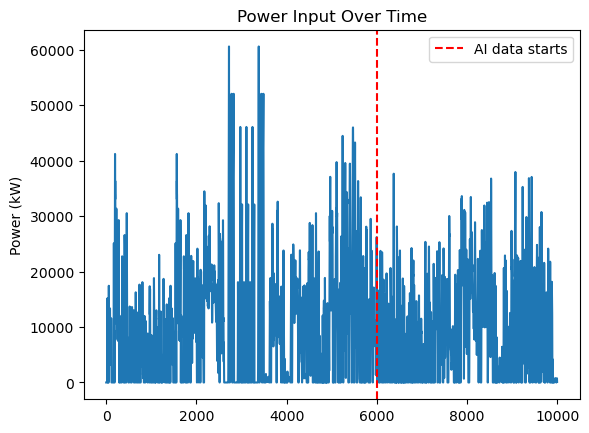

In [16]:
plt.plot(power_input[:10000])
plt.axvline(6000, color='r', linestyle='--', label='AI data starts')
plt.title("Power Input Over Time")
plt.ylabel("Power (kW)")
plt.legend()

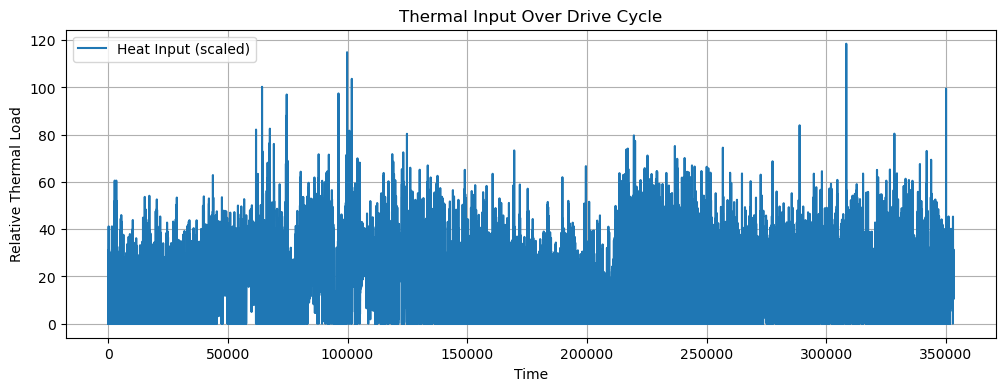

In [17]:
plt.figure(figsize=(12, 4))
heat_regions = power_input * 1e-3  # from simulation
plt.plot(time, heat_regions, label="Heat Input (scaled)")
plt.title("Thermal Input Over Drive Cycle")
plt.xlabel("Time")
plt.ylabel("Relative Thermal Load")
plt.grid(True)
plt.legend()
plt.show()

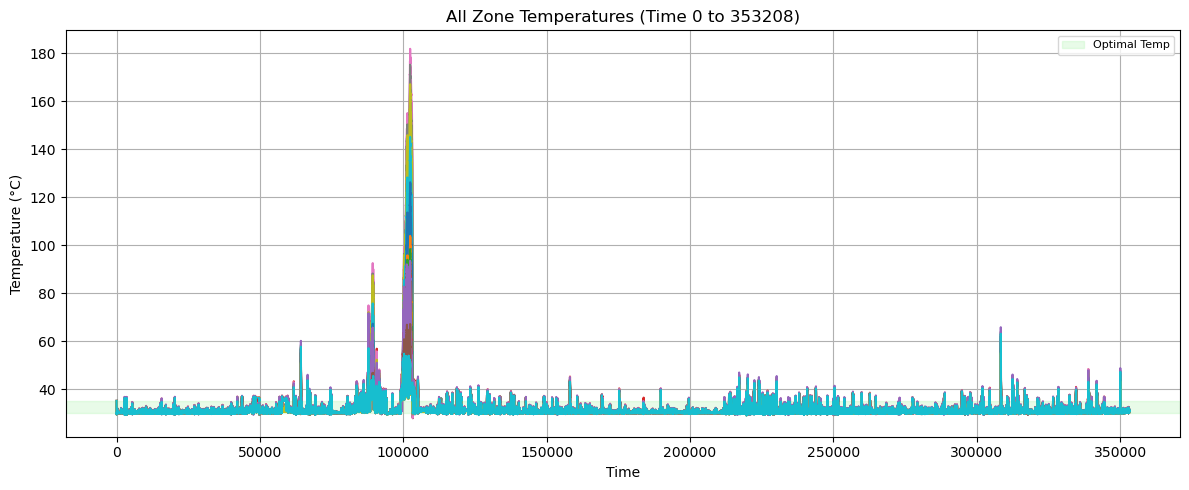

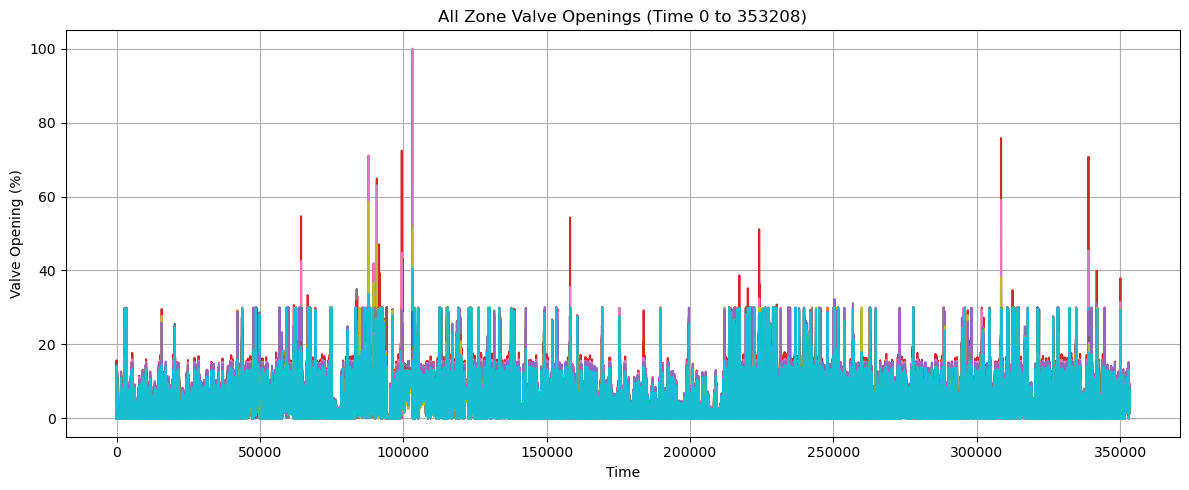

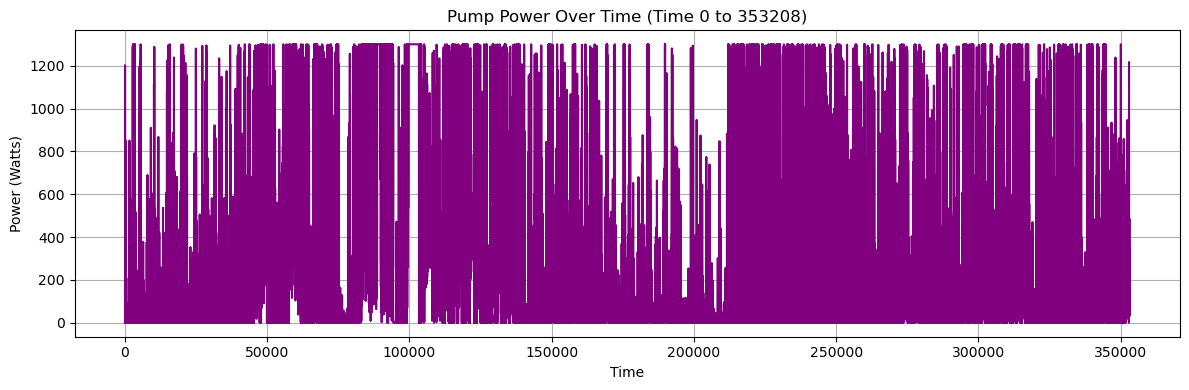

In [20]:
# Time range selection (edit these values as needed)
start_time = 0
end_time = len(time)  # e.g., 0–500 steps, or len(time) for full

# Clamp range to safe bounds
start_time = max(0, start_time)
end_time = min(len(time), end_time)

# Slice the time range
t_range = slice(start_time, end_time)

# 🔥 Plot all zone temperatures
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], temps[t_range, :])
plt.axhspan(30, 35, color='lightgreen', alpha=0.2, label="Optimal Temp")
plt.title(f"All Zone Temperatures (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# 🔧 Plot all valve openings
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], valves[t_range, :])
plt.title(f"All Zone Valve Openings (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Valve Opening (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ⚡ Plot pump power
plt.figure(figsize=(12, 4))
plt.plot(time[t_range], pump_power[t_range], color="purple")
plt.title(f"Pump Power Over Time (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame({"Time": time})
for z in range(num_zones):
    df[f"ZoneTemp_{z+1}"] = temps[:, z]
    df[f"ValveOpen_{z+1}"] = valves[:, z]
df.to_csv("/home/keshav/Documents/reserch_code/simulated_battery_cooling.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/ASUS/Documents/reserch_code/simulated_battery_cooling.csv'